# Steps to Generate Standardized Streamflow Index Using GloFAS-ERA5 Data

To generate the **Standardized Streamflow Index** ([SSI](https://doi.org/10.1029/2019WR026315)) - as proxy for hydrological drought, we will use daily gridded **River discharge in the last 24 hours** from GloFAS-ERA5 operational global river discharge reanalysis 1979–present (paper: [https://doi.org/10.5194/essd-12-2043-2020](https://doi.org/10.5194/essd-12-2043-2020)) as a proxy for the streamflow time series infomation. 

The data it self are available for download from the [https://cds.climate.copernicus.eu/cdsapp#!/dataset/cems-glofas-historical?tab=overview](https://cds.climate.copernicus.eu/cdsapp#!/dataset/cems-glofas-historical?tab=overview)

Let's assume we are working in the `python` or `conda` environment, with packages installed: `nco`, `cdo`, `gdal`, `numpy`, `xarray`, `climate-indices` and probably other necessary packages.

## 0. Working Directory

For this exercise, I am working on these folder `/Temp/drought/hyd/` (applied to Mac/Linux machine) or `Z:/Temp/drought/hyd/` (applied to Windows machine) directory. I have some folder inside this directory:

1. `00_downloads` # Place to put downloaded gridded river discharge data.
2. `01_nc4` # As the downloaded files in `*.grib` format, we'll need to convert it into `*.nc4` format and put in this folder.
3. `02_shifted` # Place to put nc files from shifting the time into 1 day.
4. `03_regrid` # Place to put nc files from fill the null value near the coastline by interpolating from nearest grid process, matched the grid with the subset, and remove the value over the sea.
5. `04_monthly` # Place to put nc file on unit conversion from `m3 s-1` to `mm` process, and calculate monthly accumulation.
6. `05_single_nc` # Contain single nc file from merge process.
7. `06_metadata_revision` # Revises nc file from metadata editing before the SSI calculation.
8. `07_ssi_intermediate` # Output from SSI calculation goes here.
9. `08_ssi` # Final SSI output that is CF-Compliant.
10. `images` # In this folder I put some screenshot file as illustration, used in this notebook.

Feel free to use your own preferences for this setting/folder arrangements.

This step-by-step guide was tested using Windows 11 with WSL2 - Ubuntu 22 enabled running on Thinkpad T480 2019, i7-8650U 1.9GHz, 64 GB 2400 MHz DDR4.

## 1. Download the data

Navigate to `00_downloads` folder

In [1]:
%cd ./hyd/00_downloads

/Volumes/Datenspeicherung/Temp/drought/hyd/00_downloads


Then execute below code to download the data. Make sure you are registered to the [CDS](https://cds.climate.copernicus.eu/cdsapp#!/home), and have an UID:ApiKey (you can find this in your profile)

In [10]:
import os
import cdsapi

# Replace UID:ApiKey with your UID and API key
# c = cdsapi.Client(key="UID:ApiKey")
c = cdsapi.Client()

years = list(range(1981, 2023))

for year in years:
    c.retrieve(
    'cems-glofas-historical',
    {
        'system_version': 'version_3_1',
        'variable': 'river_discharge_in_the_last_24_hours',
        'hydrological_model': 'lisflood',
        'product_type': 'consolidated',
        'hyear': str(year),
        'hmonth': [
            'april', 'august', 'december',
            'february', 'january', 'july',
            'june', 'march', 'may',
            'november', 'october', 'september',
        ],
        'hday': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
            '13', '14', '15',
            '16', '17', '18',
            '19', '20', '21',
            '22', '23', '24',
            '25', '26', '27',
            '28', '29', '30',
            '31',
        ],
        'area': [
            11, 90, -13, 145, # Bounding box for Indonesia
        ],
        'format': 'grib',
    },
    'idn_cli_era5_riverdischarge_' + str(year) + '.grib')

    print('idn_cli_era5_riverdischarge_' + str(year) + '.grib' + ' downloaded.')

2023-11-30 12:50:34,298 INFO Welcome to the CDS
2023-11-30 12:50:34,299 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/cems-glofas-historical
2023-11-30 12:50:34,566 INFO Request is queued
2023-11-30 12:50:35,764 INFO Request is running
2023-11-30 12:51:25,412 INFO Request is completed
2023-11-30 12:51:25,413 INFO Downloading https://download-0017.copernicus-climate.eu/cache-compute-0017/cache/data3/adaptor.mars.external-1701323434.7039516-17706-2-4c1fee05-6a6d-47e4-9f41-cdee76272e4f.grib to idn_cli_era5_riverdischarge_1981.grib (31.2M)
2023-11-30 12:51:30,877 INFO Download rate 5.7M/s                                                                               
2023-11-30 12:51:31,268 INFO Welcome to the CDS
2023-11-30 12:51:31,269 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/cems-glofas-historical


idn_cli_era5_riverdischarge_1981.grib downloaded.


2023-11-30 12:51:31,543 INFO Request is queued
2023-11-30 12:51:32,746 INFO Request is running
2023-11-30 12:52:48,211 INFO Request is completed
2023-11-30 12:52:48,212 INFO Downloading https://download-0005-clone.copernicus-climate.eu/cache-compute-0005/cache/data3/adaptor.mars.external-1701323491.7087302-7252-12-9a852f0d-7521-4f51-9296-9f865cbdd685.grib to idn_cli_era5_riverdischarge_1982.grib (31.2M)
2023-11-30 12:53:43,013 INFO Download rate 583.1K/s                                                                             
2023-11-30 12:53:43,407 INFO Welcome to the CDS
2023-11-30 12:53:43,408 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/cems-glofas-historical


idn_cli_era5_riverdischarge_1982.grib downloaded.


2023-11-30 12:53:43,684 INFO Request is queued
2023-11-30 12:53:44,880 INFO Request is running
2023-11-30 12:55:00,380 INFO Request is completed
2023-11-30 12:55:00,381 INFO Downloading https://download-0011-clone.copernicus-climate.eu/cache-compute-0011/cache/data3/adaptor.mars.external-1701323623.976512-27701-6-517712a3-72fa-4f6d-a589-a2e14bd0bd77.grib to idn_cli_era5_riverdischarge_1983.grib (31.2M)
2023-11-30 12:56:09,822 INFO Download rate 460.1K/s                                                                             
2023-11-30 12:56:10,792 INFO Welcome to the CDS
2023-11-30 12:56:10,793 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/cems-glofas-historical


idn_cli_era5_riverdischarge_1983.grib downloaded.


2023-11-30 12:56:11,015 INFO Request is queued
2023-11-30 12:56:12,210 INFO Request is running
2023-11-30 12:57:27,629 INFO Request is completed
2023-11-30 12:57:27,630 INFO Downloading https://download-0018.copernicus-climate.eu/cache-compute-0018/cache/data1/adaptor.mars.external-1701323771.2619767-22137-14-4c256afb-e299-4a64-9352-c9afe791b651.grib to idn_cli_era5_riverdischarge_1984.grib (31.3M)
2023-11-30 12:59:10,912 INFO Download rate 310.2K/s                                                                             
2023-11-30 12:59:11,946 INFO Welcome to the CDS


idn_cli_era5_riverdischarge_1984.grib downloaded.


2023-11-30 12:59:11,947 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/cems-glofas-historical
2023-11-30 12:59:12,186 INFO Request is queued
2023-11-30 12:59:13,373 INFO Request is running
2023-11-30 13:00:28,756 INFO Request is completed
2023-11-30 13:00:28,757 INFO Downloading https://download-0005-clone.copernicus-climate.eu/cache-compute-0005/cache/data3/adaptor.mars.external-1701323952.398372-15620-12-fb29c100-8930-4cda-b589-cdce4e26400c.grib to idn_cli_era5_riverdischarge_1985.grib (31.2M)
2023-11-30 13:00:50,997 INFO Download rate 1.4M/s                                                                               
2023-11-30 13:00:51,367 INFO Welcome to the CDS
2023-11-30 13:00:51,368 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/cems-glofas-historical


idn_cli_era5_riverdischarge_1985.grib downloaded.


2023-11-30 13:00:51,599 INFO Request is queued
2023-11-30 13:00:52,786 INFO Request is running
2023-11-30 13:02:08,162 INFO Request is completed
2023-11-30 13:02:08,163 INFO Downloading https://download-0003-clone.copernicus-climate.eu/cache-compute-0003/cache/data2/adaptor.mars.external-1701324052.6162405-30488-5-76b85a95-b8c5-4725-bc03-44d8680e43c3.grib to idn_cli_era5_riverdischarge_1986.grib (31.2M)
2023-11-30 13:02:15,972 INFO Download rate 4M/s                                                                                 
2023-11-30 13:02:16,344 INFO Welcome to the CDS
2023-11-30 13:02:16,344 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/cems-glofas-historical


idn_cli_era5_riverdischarge_1986.grib downloaded.


2023-11-30 13:02:16,560 INFO Request is queued
2023-11-30 13:02:17,747 INFO Request is running
2023-11-30 13:03:33,131 INFO Request is completed
2023-11-30 13:03:33,132 INFO Downloading https://download-0004-clone.copernicus-climate.eu/cache-compute-0004/cache/data3/adaptor.mars.external-1701324136.8192842-24961-8-4e15fe36-f573-4ee8-87ea-0c2cfd845960.grib to idn_cli_era5_riverdischarge_1987.grib (31.2M)
2023-11-30 13:03:38,854 INFO Download rate 5.5M/s                                                                               
2023-11-30 13:03:39,225 INFO Welcome to the CDS
2023-11-30 13:03:39,226 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/cems-glofas-historical


idn_cli_era5_riverdischarge_1987.grib downloaded.


2023-11-30 13:03:39,437 INFO Request is queued
2023-11-30 13:03:40,628 INFO Request is running
2023-11-30 13:04:30,214 INFO Request is completed
2023-11-30 13:04:30,215 INFO Downloading https://download-0010-clone.copernicus-climate.eu/cache-compute-0010/cache/data5/adaptor.mars.external-1701324219.6358535-4007-4-6e01044e-b6d0-4f4c-95c6-be40581b2099.grib to idn_cli_era5_riverdischarge_1988.grib (31.3M)
2023-11-30 13:04:37,325 INFO Download rate 4.4M/s                                                                               
2023-11-30 13:04:37,697 INFO Welcome to the CDS
2023-11-30 13:04:37,698 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/cems-glofas-historical


idn_cli_era5_riverdischarge_1988.grib downloaded.


2023-11-30 13:04:37,911 INFO Request is queued
2023-11-30 13:04:39,102 INFO Request is running
2023-11-30 13:05:28,683 INFO Request is completed
2023-11-30 13:05:28,684 INFO Downloading https://download-0012-clone.copernicus-climate.eu/cache-compute-0012/cache/data4/adaptor.mars.external-1701324278.097328-2567-9-ef2c23ad-3003-4775-bf5a-d3b6deac7dc6.grib to idn_cli_era5_riverdischarge_1989.grib (31.2M)
2023-11-30 13:05:34,238 INFO Download rate 5.6M/s                                                                               
2023-11-30 13:05:34,610 INFO Welcome to the CDS
2023-11-30 13:05:34,611 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/cems-glofas-historical


idn_cli_era5_riverdischarge_1989.grib downloaded.


2023-11-30 13:05:34,834 INFO Request is queued
2023-11-30 13:05:36,025 INFO Request is running
2023-11-30 13:06:51,418 INFO Request is completed
2023-11-30 13:06:51,419 INFO Downloading https://download-0010-clone.copernicus-climate.eu/cache-compute-0010/cache/data5/adaptor.mars.external-1701324335.01892-5027-5-b917cbfd-ba42-4474-a580-4e399219bf9d.grib to idn_cli_era5_riverdischarge_1990.grib (31.2M)
2023-11-30 13:07:23,879 INFO Download rate 984.4K/s                                                                             
2023-11-30 13:07:24,251 INFO Welcome to the CDS
2023-11-30 13:07:24,252 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/cems-glofas-historical


idn_cli_era5_riverdischarge_1990.grib downloaded.


2023-11-30 13:07:24,467 INFO Request is queued
2023-11-30 13:07:25,655 INFO Request is running
2023-11-30 13:08:41,047 INFO Request is completed
2023-11-30 13:08:41,048 INFO Downloading https://download-0013-clone.copernicus-climate.eu/cache-compute-0013/cache/data1/adaptor.mars.external-1701324444.8612409-4989-9-0c573de2-be6b-4432-bec2-b6a452bdb27e.grib to idn_cli_era5_riverdischarge_1991.grib (31.2M)
2023-11-30 13:09:28,866 INFO Download rate 668.2K/s                                                                             
2023-11-30 13:09:29,238 INFO Welcome to the CDS
2023-11-30 13:09:29,238 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/cems-glofas-historical


idn_cli_era5_riverdischarge_1991.grib downloaded.


2023-11-30 13:09:29,441 INFO Request is queued
2023-11-30 13:09:30,631 INFO Request is running
2023-11-30 13:10:46,051 INFO Request is completed
2023-11-30 13:10:46,052 INFO Downloading https://download-0019.copernicus-climate.eu/cache-compute-0019/cache/data7/adaptor.mars.external-1701324569.708631-32679-6-a117ef14-d9c9-4974-b90a-b22f7f57e550.grib to idn_cli_era5_riverdischarge_1992.grib (31.3M)
2023-11-30 13:11:16,151 INFO Download rate 1M/s                                                                                 
2023-11-30 13:11:16,527 INFO Welcome to the CDS
2023-11-30 13:11:16,527 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/cems-glofas-historical


idn_cli_era5_riverdischarge_1992.grib downloaded.


2023-11-30 13:11:16,739 INFO Request is queued
2023-11-30 13:11:17,929 INFO Request is running
2023-11-30 13:12:33,916 INFO Request is completed
2023-11-30 13:12:33,917 INFO Downloading https://download-0016.copernicus-climate.eu/cache-compute-0016/cache/data4/adaptor.mars.external-1701324677.0068746-31656-11-ae191859-1f70-4f21-bd64-4052b5754074.grib to idn_cli_era5_riverdischarge_1993.grib (31.2M)
2023-11-30 13:13:15,493 INFO Download rate 768.5K/s                                                                             
2023-11-30 13:13:15,891 INFO Welcome to the CDS
2023-11-30 13:13:15,892 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/cems-glofas-historical


idn_cli_era5_riverdischarge_1993.grib downloaded.


2023-11-30 13:13:16,127 INFO Request is queued
2023-11-30 13:13:17,317 INFO Request is running
2023-11-30 13:14:06,908 INFO Request is completed
2023-11-30 13:14:06,909 INFO Downloading https://download-0013-clone.copernicus-climate.eu/cache-compute-0013/cache/data2/adaptor.mars.external-1701324796.5511801-6762-13-82cd9245-420d-40b2-8a3d-6edfeca572d1.grib to idn_cli_era5_riverdischarge_1994.grib (31.2M)
2023-11-30 13:14:12,555 INFO Download rate 5.5M/s                                                                               
2023-11-30 13:14:12,932 INFO Welcome to the CDS
2023-11-30 13:14:12,933 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/cems-glofas-historical


idn_cli_era5_riverdischarge_1994.grib downloaded.


2023-11-30 13:14:13,160 INFO Request is queued
2023-11-30 13:14:14,351 INFO Request is running
2023-11-30 13:15:29,761 INFO Request is completed
2023-11-30 13:15:29,762 INFO Downloading https://download-0000-clone.copernicus-climate.eu/cache-compute-0000/cache/data8/adaptor.mars.external-1701324853.3992224-32103-12-24dce134-48d7-4589-a3a0-5e6b1687e4ad.grib to idn_cli_era5_riverdischarge_1995.grib (31.2M)
2023-11-30 13:16:18,896 INFO Download rate 650.3K/s                                                                             
2023-11-30 13:16:19,272 INFO Welcome to the CDS
2023-11-30 13:16:19,273 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/cems-glofas-historical


idn_cli_era5_riverdischarge_1995.grib downloaded.


2023-11-30 13:16:19,499 INFO Request is queued
2023-11-30 13:16:20,690 INFO Request is running
2023-11-30 13:17:10,274 INFO Request is completed
2023-11-30 13:17:10,275 INFO Downloading https://download-0014-clone.copernicus-climate.eu/cache-compute-0014/cache/data4/adaptor.mars.external-1701324979.8943677-21353-1-aab444c8-fc5a-4595-9996-1e65657e89fd.grib to idn_cli_era5_riverdischarge_1996.grib (31.3M)
2023-11-30 13:17:16,330 INFO Download rate 5.2M/s                                                                               
2023-11-30 13:17:16,708 INFO Welcome to the CDS
2023-11-30 13:17:16,709 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/cems-glofas-historical


idn_cli_era5_riverdischarge_1996.grib downloaded.


2023-11-30 13:17:16,921 INFO Request is queued
2023-11-30 13:17:18,111 INFO Request is running
2023-11-30 13:18:33,530 INFO Request is completed
2023-11-30 13:18:33,531 INFO Downloading https://download-0018.copernicus-climate.eu/cache-compute-0018/cache/data4/adaptor.mars.external-1701325037.152625-6434-2-b5bbca3d-4463-4dbe-8bed-7abe0719c392.grib to idn_cli_era5_riverdischarge_1997.grib (31.2M)
2023-11-30 13:19:53,714 INFO Download rate 398.5K/s                                                                             
2023-11-30 13:19:54,629 INFO Welcome to the CDS
2023-11-30 13:19:54,630 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/cems-glofas-historical


idn_cli_era5_riverdischarge_1997.grib downloaded.


2023-11-30 13:19:54,863 INFO Request is queued
2023-11-30 13:19:56,049 INFO Request is running
2023-11-30 13:20:45,604 INFO Request is completed
2023-11-30 13:20:45,605 INFO Downloading https://download-0007-clone.copernicus-climate.eu/cache-compute-0007/cache/data7/adaptor.mars.external-1701325195.140783-6686-6-38b96935-e231-4d94-a16b-e66e81144f05.grib to idn_cli_era5_riverdischarge_1998.grib (31.2M)
2023-11-30 13:21:20,661 INFO Download rate 911.5K/s                                                                             
2023-11-30 13:21:21,023 INFO Welcome to the CDS
2023-11-30 13:21:21,024 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/cems-glofas-historical


idn_cli_era5_riverdischarge_1998.grib downloaded.


2023-11-30 13:21:21,234 INFO Request is queued
2023-11-30 13:21:22,416 INFO Request is running
2023-11-30 13:22:37,766 INFO Request is completed
2023-11-30 13:22:37,767 INFO Downloading https://download-0016.copernicus-climate.eu/cache-compute-0016/cache/data4/adaptor.mars.external-1701325281.6294858-32114-11-2a18c31d-ba24-4bf1-95a2-12655a094481.grib to idn_cli_era5_riverdischarge_1999.grib (31.2M)
2023-11-30 13:23:04,507 INFO Download rate 1.2M/s                                                                               
2023-11-30 13:23:04,867 INFO Welcome to the CDS
2023-11-30 13:23:04,868 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/cems-glofas-historical


idn_cli_era5_riverdischarge_1999.grib downloaded.


2023-11-30 13:23:05,098 INFO Request is queued
2023-11-30 13:23:06,282 INFO Request is running
2023-11-30 13:24:21,620 INFO Request is completed
2023-11-30 13:24:21,621 INFO Downloading https://download-0007-clone.copernicus-climate.eu/cache-compute-0007/cache/data2/adaptor.mars.external-1701325385.5981681-4102-19-14f1e62c-c9a5-4bd6-8277-d4efe762b833.grib to idn_cli_era5_riverdischarge_2000.grib (31.3M)
2023-11-30 13:24:27,825 INFO Download rate 5M/s                                                                                 
2023-11-30 13:24:28,217 INFO Welcome to the CDS
2023-11-30 13:24:28,218 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/cems-glofas-historical


idn_cli_era5_riverdischarge_2000.grib downloaded.


2023-11-30 13:24:28,431 INFO Request is queued
2023-11-30 13:24:29,616 INFO Request is running
2023-11-30 13:25:44,968 INFO Request is completed
2023-11-30 13:25:44,968 INFO Downloading https://download-0015-clone.copernicus-climate.eu/cache-compute-0015/cache/data0/adaptor.mars.external-1701325468.7090218-19545-17-ae1f2b85-c08e-4021-af48-9d3d7370fd8b.grib to idn_cli_era5_riverdischarge_2001.grib (31.2M)
2023-11-30 13:26:16,344 INFO Download rate 1018.4K/s                                                                            
2023-11-30 13:26:16,703 INFO Welcome to the CDS
2023-11-30 13:26:16,704 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/cems-glofas-historical


idn_cli_era5_riverdischarge_2001.grib downloaded.


2023-11-30 13:26:16,930 INFO Request is queued
2023-11-30 13:26:18,113 INFO Request is running
2023-11-30 13:27:07,639 INFO Request is completed
2023-11-30 13:27:07,640 INFO Downloading https://download-0005-clone.copernicus-climate.eu/cache-compute-0005/cache/data9/adaptor.mars.external-1701325577.2478259-24635-10-0205f56b-00f4-445f-b32d-b8f44ad33a0a.grib to idn_cli_era5_riverdischarge_2002.grib (31.2M)
2023-11-30 13:27:13,426 INFO Download rate 5.4M/s                                                                               
2023-11-30 13:27:13,785 INFO Welcome to the CDS
2023-11-30 13:27:13,786 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/cems-glofas-historical


idn_cli_era5_riverdischarge_2002.grib downloaded.


2023-11-30 13:27:14,044 INFO Request is queued
2023-11-30 13:27:15,227 INFO Request is running
2023-11-30 13:28:30,565 INFO Request is completed
2023-11-30 13:28:30,566 INFO Downloading https://download-0002-clone.copernicus-climate.eu/cache-compute-0002/cache/data8/adaptor.mars.external-1701325634.4885843-5828-1-3277977f-92dd-42f4-9f78-1c2c88dfafd3.grib to idn_cli_era5_riverdischarge_2003.grib (31.2M)
2023-11-30 13:29:05,190 INFO Download rate 922.8K/s                                                                             
2023-11-30 13:29:05,552 INFO Welcome to the CDS
2023-11-30 13:29:05,553 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/cems-glofas-historical


idn_cli_era5_riverdischarge_2003.grib downloaded.


2023-11-30 13:29:05,795 INFO Request is queued
2023-11-30 13:29:06,976 INFO Request is running
2023-11-30 13:30:22,337 INFO Request is completed
2023-11-30 13:30:22,338 INFO Downloading https://download-0008-clone.copernicus-climate.eu/cache-compute-0008/cache/data4/adaptor.mars.external-1701325746.3043451-26486-10-36589057-5156-460d-ac37-1ca613b23b58.grib to idn_cli_era5_riverdischarge_2004.grib (31.3M)
2023-11-30 13:30:45,829 INFO Download rate 1.3M/s                                                                               
2023-11-30 13:30:46,188 INFO Welcome to the CDS
2023-11-30 13:30:46,189 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/cems-glofas-historical


idn_cli_era5_riverdischarge_2004.grib downloaded.


2023-11-30 13:30:46,423 INFO Request is queued
2023-11-30 13:30:47,608 INFO Request is running
2023-11-30 13:31:37,150 INFO Request is completed
2023-11-30 13:31:37,151 INFO Downloading https://download-0011-clone.copernicus-climate.eu/cache-compute-0011/cache/data5/adaptor.mars.external-1701325846.8179824-19374-15-f2175b5f-8133-4aaa-a4a9-74d77a7651ce.grib to idn_cli_era5_riverdischarge_2005.grib (31.2M)
2023-11-30 13:31:42,662 INFO Download rate 5.7M/s                                                                               
2023-11-30 13:31:43,022 INFO Welcome to the CDS
2023-11-30 13:31:43,022 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/cems-glofas-historical


idn_cli_era5_riverdischarge_2005.grib downloaded.


2023-11-30 13:31:43,316 INFO Request is queued
2023-11-30 13:31:44,497 INFO Request is running
2023-11-30 13:33:00,471 INFO Request is completed
2023-11-30 13:33:00,472 INFO Downloading https://download-0006-clone.copernicus-climate.eu/cache-compute-0006/cache/data6/adaptor.mars.external-1701325903.657964-6265-2-1c6c8151-0fb1-4f8d-acb1-b641faa05ee4.grib to idn_cli_era5_riverdischarge_2006.grib (31.2M)
2023-11-30 13:33:11,090 INFO Download rate 2.9M/s                                                                               
2023-11-30 13:33:11,474 INFO Welcome to the CDS
2023-11-30 13:33:11,475 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/cems-glofas-historical


idn_cli_era5_riverdischarge_2006.grib downloaded.


2023-11-30 13:33:11,694 INFO Request is queued
2023-11-30 13:33:12,886 INFO Request is running
2023-11-30 13:34:28,413 INFO Request is completed
2023-11-30 13:34:28,414 INFO Downloading https://download-0020.copernicus-climate.eu/cache-compute-0020/cache/data7/adaptor.mars.external-1701325992.0206978-17142-8-3b5f1895-df05-468b-be34-19250e5dcd2f.grib to idn_cli_era5_riverdischarge_2007.grib (31.2M)
2023-11-30 13:34:34,984 INFO Download rate 4.7M/s                                                                               
2023-11-30 13:34:35,365 INFO Welcome to the CDS
2023-11-30 13:34:35,366 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/cems-glofas-historical


idn_cli_era5_riverdischarge_2007.grib downloaded.


2023-11-30 13:34:35,613 INFO Request is queued
2023-11-30 13:34:36,804 INFO Request is running
2023-11-30 13:35:52,236 INFO Request is completed
2023-11-30 13:35:52,237 INFO Downloading https://download-0009-clone.copernicus-climate.eu/cache-compute-0009/cache/data0/adaptor.mars.external-1701326075.9346337-16817-7-9b753163-06d0-4307-976f-b291da518834.grib to idn_cli_era5_riverdischarge_2008.grib (31.3M)
2023-11-30 13:36:16,291 INFO Download rate 1.3M/s                                                                               
2023-11-30 13:36:16,673 INFO Welcome to the CDS
2023-11-30 13:36:16,674 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/cems-glofas-historical


idn_cli_era5_riverdischarge_2008.grib downloaded.


2023-11-30 13:36:16,910 INFO Request is queued
2023-11-30 13:36:18,102 INFO Request is running
2023-11-30 13:37:07,709 INFO Request is completed
2023-11-30 13:37:07,710 INFO Downloading https://download-0003-clone.copernicus-climate.eu/cache-compute-0003/cache/data7/adaptor.mars.external-1701326177.1687746-6756-20-63ee3fe4-2582-492f-8a75-e427054a75b9.grib to idn_cli_era5_riverdischarge_2009.grib (31.2M)
2023-11-30 13:37:13,340 INFO Download rate 5.5M/s                                                                               
2023-11-30 13:37:13,722 INFO Welcome to the CDS
2023-11-30 13:37:13,723 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/cems-glofas-historical


idn_cli_era5_riverdischarge_2009.grib downloaded.


2023-11-30 13:37:13,950 INFO Request is queued
2023-11-30 13:37:15,145 INFO Request is running
2023-11-30 13:38:04,780 INFO Request is completed
2023-11-30 13:38:04,781 INFO Downloading https://download-0008-clone.copernicus-climate.eu/cache-compute-0008/cache/data0/adaptor.mars.external-1701326234.5116346-7024-1-10cf8e28-8908-4560-a30a-516ac9f0b3f1.grib to idn_cli_era5_riverdischarge_2010.grib (31.2M)
2023-11-30 13:38:10,011 INFO Download rate 6M/s                                                                                 
2023-11-30 13:38:10,391 INFO Welcome to the CDS
2023-11-30 13:38:10,392 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/cems-glofas-historical


idn_cli_era5_riverdischarge_2010.grib downloaded.


2023-11-30 13:38:10,628 INFO Request is queued
2023-11-30 13:38:11,819 INFO Request is running
2023-11-30 13:39:01,429 INFO Request is completed
2023-11-30 13:39:01,430 INFO Downloading https://download-0019.copernicus-climate.eu/cache-compute-0019/cache/data4/adaptor.mars.external-1701326291.0030077-18361-9-e7be3e52-a1a9-4aaf-a105-d87680c66e5c.grib to idn_cli_era5_riverdischarge_2011.grib (31.2M)
2023-11-30 13:39:08,582 INFO Download rate 4.4M/s                                                                               
2023-11-30 13:39:08,967 INFO Welcome to the CDS
2023-11-30 13:39:08,968 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/cems-glofas-historical


idn_cli_era5_riverdischarge_2011.grib downloaded.


2023-11-30 13:39:09,212 INFO Request is queued
2023-11-30 13:39:10,406 INFO Request is running
2023-11-30 13:40:00,005 INFO Request is completed
2023-11-30 13:40:00,006 INFO Downloading https://download-0012-clone.copernicus-climate.eu/cache-compute-0012/cache/data3/adaptor.mars.external-1701326349.583342-27036-14-e2be9f86-25e9-4c34-a6d6-04773fae7232.grib to idn_cli_era5_riverdischarge_2012.grib (31.3M)
2023-11-30 13:40:15,547 INFO Download rate 2M/s                                                                                 
2023-11-30 13:40:15,933 INFO Welcome to the CDS
2023-11-30 13:40:15,934 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/cems-glofas-historical


idn_cli_era5_riverdischarge_2012.grib downloaded.


2023-11-30 13:40:16,183 INFO Request is queued
2023-11-30 13:40:17,376 INFO Request is running
2023-11-30 13:41:32,797 INFO Request is completed
2023-11-30 13:41:32,798 INFO Downloading https://download-0018.copernicus-climate.eu/cache-compute-0018/cache/data5/adaptor.mars.external-1701326416.6793103-16558-13-6ff5536a-1831-4720-80f4-f59505c8100a.grib to idn_cli_era5_riverdischarge_2013.grib (31.2M)
2023-11-30 13:41:41,726 INFO Download rate 3.5M/s                                                                               
2023-11-30 13:41:42,106 INFO Welcome to the CDS
2023-11-30 13:41:42,106 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/cems-glofas-historical


idn_cli_era5_riverdischarge_2013.grib downloaded.


2023-11-30 13:41:42,370 INFO Request is queued
2023-11-30 13:41:43,561 INFO Request is running
2023-11-30 13:42:58,981 INFO Request is completed
2023-11-30 13:42:58,982 INFO Downloading https://download-0016.copernicus-climate.eu/cache-compute-0016/cache/data1/adaptor.mars.external-1701326502.8387418-15417-6-05faa875-9692-422e-ba5e-2352e7f20b85.grib to idn_cli_era5_riverdischarge_2014.grib (31.2M)
2023-11-30 13:43:23,263 INFO Download rate 1.3M/s                                                                               
2023-11-30 13:43:23,645 INFO Welcome to the CDS
2023-11-30 13:43:23,645 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/cems-glofas-historical


idn_cli_era5_riverdischarge_2014.grib downloaded.


2023-11-30 13:43:23,877 INFO Request is queued
2023-11-30 13:43:25,605 INFO Request is running
2023-11-30 13:44:40,927 INFO Request is completed
2023-11-30 13:44:40,928 INFO Downloading https://download-0006-clone.copernicus-climate.eu/cache-compute-0006/cache/data4/adaptor.mars.external-1701326604.264344-7747-11-af4dd216-a905-40c5-a195-b594d53773b5.grib to idn_cli_era5_riverdischarge_2015.grib (31.2M)
2023-11-30 13:44:46,368 INFO Download rate 5.7M/s                                                                               
2023-11-30 13:44:46,726 INFO Welcome to the CDS
2023-11-30 13:44:46,727 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/cems-glofas-historical


idn_cli_era5_riverdischarge_2015.grib downloaded.


2023-11-30 13:44:46,967 INFO Request is queued
2023-11-30 13:44:48,151 INFO Request is running
2023-11-30 13:46:03,486 INFO Request is completed
2023-11-30 13:46:03,487 INFO Downloading https://download-0020.copernicus-climate.eu/cache-compute-0020/cache/data2/adaptor.mars.external-1701326687.5053134-21411-5-17132168-394b-4d9a-99ba-4de7a2ddb8d6.grib to idn_cli_era5_riverdischarge_2016.grib (31.3M)
2023-11-30 13:46:09,967 INFO Download rate 4.8M/s                                                                               
2023-11-30 13:46:10,329 INFO Welcome to the CDS
2023-11-30 13:46:10,330 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/cems-glofas-historical


idn_cli_era5_riverdischarge_2016.grib downloaded.


2023-11-30 13:46:10,562 INFO Request is queued
2023-11-30 13:46:11,746 INFO Request is running
2023-11-30 13:47:27,079 INFO Request is completed
2023-11-30 13:47:27,079 INFO Downloading https://download-0013-clone.copernicus-climate.eu/cache-compute-0013/cache/data6/adaptor.mars.external-1701326770.9698944-23804-15-3d56c23d-893e-4963-bfde-060246f92b8f.grib to idn_cli_era5_riverdischarge_2017.grib (31.2M)
2023-11-30 13:48:11,595 INFO Download rate 717.8K/s                                                                             
2023-11-30 13:48:11,958 INFO Welcome to the CDS
2023-11-30 13:48:11,959 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/cems-glofas-historical


idn_cli_era5_riverdischarge_2017.grib downloaded.


2023-11-30 13:48:12,198 INFO Request is queued
2023-11-30 13:48:13,377 INFO Request is running
2023-11-30 13:49:28,693 INFO Request is completed
2023-11-30 13:49:28,694 INFO Downloading https://download-0000-clone.copernicus-climate.eu/cache-compute-0000/cache/data9/adaptor.mars.external-1701326892.6099937-8144-9-ad3a1324-dbfb-4f7f-ad4f-54818e1be58f.grib to idn_cli_era5_riverdischarge_2018.grib (31.2M)
2023-11-30 13:50:53,278 INFO Download rate 377.8K/s                                                                             
2023-11-30 13:50:54,231 INFO Welcome to the CDS
2023-11-30 13:50:54,232 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/cems-glofas-historical


idn_cli_era5_riverdischarge_2018.grib downloaded.


2023-11-30 13:50:54,459 INFO Request is queued
2023-11-30 13:50:55,646 INFO Request is running
2023-11-30 13:52:11,031 INFO Request is completed
2023-11-30 13:52:11,032 INFO Downloading https://download-0018.copernicus-climate.eu/cache-compute-0018/cache/data1/adaptor.mars.external-1701327054.8118534-19454-14-2f4294d7-d2a3-43cd-a380-742813c9d242.grib to idn_cli_era5_riverdischarge_2019.grib (31.2M)
2023-11-30 13:52:16,514 INFO Download rate 5.7M/s                                                                               
2023-11-30 13:52:16,892 INFO Welcome to the CDS
2023-11-30 13:52:16,893 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/cems-glofas-historical


idn_cli_era5_riverdischarge_2019.grib downloaded.


2023-11-30 13:52:17,102 INFO Request is queued
2023-11-30 13:52:18,294 INFO Request is running
2023-11-30 13:53:33,690 INFO Request is completed
2023-11-30 13:53:33,691 INFO Downloading https://download-0019.copernicus-climate.eu/cache-compute-0019/cache/data4/adaptor.mars.external-1701327137.531536-25693-7-223f010d-667f-49d6-af4a-ad45a50b4dcc.grib to idn_cli_era5_riverdischarge_2020.grib (31.3M)
2023-11-30 13:53:39,417 INFO Download rate 5.5M/s                                                                               
2023-11-30 13:53:39,790 INFO Welcome to the CDS
2023-11-30 13:53:39,791 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/cems-glofas-historical


idn_cli_era5_riverdischarge_2020.grib downloaded.


2023-11-30 13:53:40,023 INFO Request is queued
2023-11-30 13:53:41,212 INFO Request is running
2023-11-30 13:54:56,610 INFO Request is completed
2023-11-30 13:54:56,611 INFO Downloading https://download-0010-clone.copernicus-climate.eu/cache-compute-0010/cache/data3/adaptor.mars.external-1701327220.6063886-32120-1-5869ccb5-b2c7-49c8-8e41-b87b4976cf43.grib to idn_cli_era5_riverdischarge_2021.grib (31.2M)
2023-11-30 13:55:44,285 INFO Download rate 670.2K/s                                                                             
2023-11-30 13:55:44,659 INFO Welcome to the CDS
2023-11-30 13:55:44,660 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/cems-glofas-historical


idn_cli_era5_riverdischarge_2021.grib downloaded.


2023-11-30 13:55:45,031 INFO Request is queued
2023-11-30 13:55:46,220 INFO Request is running
2023-11-30 13:57:01,611 INFO Request is completed
2023-11-30 13:57:01,612 INFO Downloading https://download-0020.copernicus-climate.eu/cache-compute-0020/cache/data6/adaptor.mars.external-1701327345.3676622-30110-4-5b3ed999-b150-4463-a464-d860472256f9.grib to idn_cli_era5_riverdischarge_2022.grib (31.2M)
2023-11-30 13:58:18,073 INFO Download rate 417.9K/s                                                                             


idn_cli_era5_riverdischarge_2022.grib downloaded.


Convert all the grib file into netcdf4 for easier processing in further analysis.

This command will:

1. Iterate over all `.grib` files in the current directory.
2. Use `cdo` to convert each `.grib` file to NetCDF format (`.nc4`), with compression.
3. Save the converted files in the `../01_nc4/` directory with the same base filename but with the `.nc4` extension.


In [12]:
!bash -c 'for fl in *.grib; do cdo -z zip_5 -f nc4 copy "$fl" "../01_nc4/${fl%.grib}.nc4"; done'


cdo    copy:   1cdo    copy: Processed 48758160 values from 1 variable over 365 timesteps [4.52s 65MB]
cdo    copy:   1cdo    copy: Processed 48758160 values from 1 variable over 365 timesteps [4.54s 65MB]
cdo    copy:   1cdo    copy: Processed 48758160 values from 1 variable over 365 timesteps [4.60s 66MB]
cdo    copy:   1cdo    copy: Processed 48891744 values from 1 variable over 366 timesteps [4.46s 65MB]
cdo    copy:   1cdo    copy: Processed 48758160 values from 1 variable over 365 timesteps [4.51s 66MB]
cdo    copy:   1cdo    copy: Processed 48758160 values from 1 variable over 365 timesteps [4.45s 65MB]
cdo    copy:   1cdo    copy: Processed 48758160 values from 1 variable over 365 timesteps [4.49s 65MB]
cdo    copy:   1cdo    copy: Processed 48891744 values from 1 variable over 366 timesteps [4.43s 65MB]
cdo    copy:   1cdo    copy: Processed 48758160 values from 1 variable over 365 timesteps [4.51s 65MB]
cdo    copy:   1cdo    copy: Processed 48758160 values from 1 variable ov

If you open one of the data using [Panoply netCDF Data Viewer](https://www.giss.nasa.gov/tools/panoply/), you can see the coverage of the data following the bounding box that you have set in the script above.

![bbox](./hyd/images/bbox_data.png)

## 2. Pre process

Navigate to folder `01_nc4`

In [2]:
%cd ../01_nc4

/Volumes/Datenspeicherung/Temp/drought/hyd/01_nc4


From above picture, we show the first date of the data, and seems it shifted 1 day (first date is 2 Jan 1981). We need to turned it back.

This script will:

* Loop over each `.nc4` file in the current directory.
* Use `cdo` to shift the time in each file backward by one day.
* Save the modified file in the `../02_shifted/` directory with the same filename.

In [20]:
!bash -c 'for fl in *.nc4; do cdo -z zip_5 shifttime,-1day $fl ../02_shifted/$fl; done'


cdo    shifttime: Processed 48758160 values from 1 variable over 365 timesteps [3.75s 69MB]
cdo    shifttime: Processed 48758160 values from 1 variable over 365 timesteps [3.64s 66MB]
cdo    shifttime: Processed 48758160 values from 1 variable over 365 timesteps [3.64s 74MB]
cdo    shifttime: Processed 48891744 values from 1 variable over 366 timesteps [3.63s 66MB]
cdo    shifttime: Processed 48758160 values from 1 variable over 365 timesteps [3.60s 66MB]
cdo    shifttime: Processed 48758160 values from 1 variable over 365 timesteps [3.67s 66MB]
cdo    shifttime: Processed 48758160 values from 1 variable over 365 timesteps [3.68s 64MB]
cdo    shifttime: Processed 48891744 values from 1 variable over 366 timesteps [3.65s 65MB]
cdo    shifttime: Processed 48758160 values from 1 variable over 365 timesteps [3.61s 65MB]
cdo    shifttime: Processed 48758160 values from 1 variable over 365 timesteps [3.67s 67MB]
cdo    shifttime: Processed 48758160 values from 1 variable over 365 timesteps [

Navigate to folder 02_shifted

In [3]:
%cd ../02_shifted

/Volumes/Datenspeicherung/Temp/drought/hyd/02_shifted


The first process will be fill the null value near the coastline by interpolating from nearest grid process, matched the grid with the subset, and remove the value over the sea.

Below script combine the operations into a one-liner script for each file, and use in-memory processing for intermediate outputs. 

This script performs the following operations for each `.nc4` file:

* `-remapbil,../subset/idn_subset_chirps.nc $fl` - Remaps the input file `$fl` to match the grid of your subset file.
* `-fillmiss -` - Fills missing values in the remapped data. The `-` symbol is used to take the output of `remapbil` as input for `fillmiss`.
* `ifthen ../subset/idn_subset_chirps.nc -` - Applies the ifthen operation using the subset file as the condition to keep data only on land. The `-` symbol takes the output of `fillmiss` as its input.
* The final output for each file is saved in the `../03_regrid/` directory.

This approach avoids writing intermediate files to disk by using in-memory streams.


In [4]:
!bash -c 'for fl in *.nc4; do cdo -z zip_5 ifthen ../../subset/idn_subset_chirps.nc -fillmiss -remapbil,../../subset/idn_subset_chirps.nc $fl ../03_regrid/$fl; done'


cdo(1) fillmiss: Process started
cdo(2) remapbil: Process started
cdo    ifthen: Filling up stream1 >../../subset/idn_subset_chirps.nc< by copying the first timestep.
cdo(2) remapbil: Bilinear weights from lonlat (552x242) to lonlat (923x341) grid, with source mask (24223)
cdo(2) remapbil:                        1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 91cdo    ifthen (Warning): Variable land has a missing value of 0, this can lead to incorrect results with this operator!
cdo(2) remapbil: Processed 48758160 values from 1 variable over 365 timesteps
cdo(1) fillmiss: Processed 114881195 values from 1 variable over 365 timesteps
cdo    ifthen: Processed 115195938 values from 2 variables over 366 timesteps [52.82s 142MB]
cdo(1) fillmiss: Process started
cdo(2) remapbil: Process started
cdo    ifthen: Filling up stream1 >../../subset/idn_subset_chirps.nc< 

If you open one of the data using **Panoply**, you can see the coverage of the data following the bounding box that you have set in the script above.

![bbox](./hyd/images/aoi_data.png)

> But if you deal with larger area of interest, please consider to write the intermediate output in a file. Use below script as example.
> 
> In this script:
> 
> * Each input file is remapped (`remapbil`) to match the grid of your subset file.
> * The remapped data then has missing values filled (`fillmiss`).
> * The `ifthen` operation is applied using the subset mask to remove sea areas.
> 
> This approach ensures that the remapped data and the subset mask are on the same grid before attempting to mask out the sea. The filling > of missing values is done after remapping to maintain consistency with the new grid.
> 
> Don't forget to remove the triple quotes `"""` at the beginning and end of the script.
> 

In [ ]:
"""
!bash -c 'for fl in *.nc4; do \
    remapped_fl="../02_regrid/remapped_$fl"; \
    final_fl="../02_regrid/$fl"; \
    cdo -z zip_5 remapbil,../subset/idn_subset_chirps.nc $fl $remapped_fl; \
    filled_fl="../02_regrid/filled_$fl"; \
    cdo -z zip_5 fillmiss $remapped_fl $filled_fl; \
    cdo -z zip_5 ifthen ../subset/idn_subset_chirps.nc $filled_fl $fl; \
done; \
rm ../02_regrid/remapped_*.nc4'
"""

## 3. Calculate daily to monthly accumulation and get the total monthly volume 

Navigate to folder `03_regrid`

In [5]:
%cd ../03_regrid

/Volumes/Datenspeicherung/Temp/drought/hyd/03_regrid


To convert an average daily discharge rate (`m³/s`) to a total monthly volume (`m³`), you would indeed sum the daily rates over the month and then multiply by the number of seconds in a day (`86,400 seconds`). This gives you the total cubic meters of water discharged in the month.

This script does the following:

* `basename_fl` extracts the base name of each file (without the `.nc4` extension).
* `monthly_fl` is the path for the monthly sum file with the `monthly_` prefix.
* `total_volume_fl` is the path for the final file without the `total_volume_` prefix in the `../03_monthly/` directory.
* After processing all files, the script removes intermediate files with the `monthly_` prefix.

In [29]:
!bash -c 'for fl in *.nc4; do \
    basename_fl=$(basename $fl .nc4); \
    monthly_fl="../04_monthly/monthly_$basename_fl.nc4"; \
    total_volume_fl="../04_monthly/$basename_fl.nc4"; \
    cdo -z zip_5 monsum $fl $monthly_fl; \
    seconds_in_day=86400; \
    cdo -z zip_5 mulc,$seconds_in_day $monthly_fl $total_volume_fl; \
done; \
rm ../04_monthly/monthly_*.nc4'


cdo    monsum:                        1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 91cdo    monsum: Processed 114881195 values from 1 variable over 365 timesteps [1.94s 74MB]
cdo    mulc: Processed 3776916 values from 1 variable over 12 timesteps [0.28s 58MB]
cdo    monsum:                        1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 91cdo    monsum: Processed 114881195 values from 1 variable over 365 timesteps [1.91s 75MB]
cdo    mulc: Processed 3776916 values from 1 variable over 12 timesteps [0.32s 60MB]
cdo    monsum:                        1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 

## 4. Combine into single netCDF and revise the metadata

Navigate to folder `04_monthly`

In [6]:
%cd ../04_monthly

/Volumes/Datenspeicherung/Temp/drought/hyd/04_monthly


Merge all `*.nc4` in a folder into single netCDF file using `mergetime`

In [31]:
!bash -c 'cdo -z zip_5 mergetime idn_*.nc4 ../05_single_nc/idn_cli_era5_riverdischarge_monthly_m3_1981_2022.nc4'

cdo    mergetime: Processed 158630472 values from 42 variables over 504 timesteps [9.72s 99MB]


## 5. Modify the metadata

Navigate to folder `05_single_nc`

In [7]:
%cd ../05_single_nc

/Volumes/Datenspeicherung/Temp/drought/hyd/05_single_nc


We need to modify/add some variables in order to prepared the data for the SSI calculation.

To rename the variable, change the `long_name`, and add a `units` attribute to the discharge variable in our NetCDF file, we can use the **NetCDF Operators** ([NCO](https://nco.sourceforge.net/)). 

The unit `mm` that we would like to add below is just for the sake of simplicity that will allow the script are working when the calculation of SSI are perform.

In [33]:
input_file = "idn_cli_era5_riverdischarge_monthly_m3_1981_2022.nc4"
output_file = f"../06_metadata_revision/{input_file}"

# Copy the original file to the new directory before making changes
!cp $input_file $output_file

# Rename the variable 'dis24' to 'discharge'
!ncrename -v dis24,discharge $output_file

# Update the 'long_name' attribute of the 'discharge' variable
!ncatted -a long_name,discharge,m,c,"Total volume discharge m3 per month" $output_file

# Add or modify the 'units' attribute of the 'discharge' variable to 'mm'
!ncatted -a units,discharge,o,c,"mm" $output_file


Let's check how it goes. Don't forget to navigate to folder `06_metadata_revision`

In [8]:
%cd ../06_metadata_revision

!ncdump -h idn_cli_era5_riverdischarge_monthly_m3_1981_2022.nc4

/Volumes/Datenspeicherung/Temp/drought/hyd/06_metadata_revision
netcdf idn_cli_era5_riverdischarge_monthly_m3_1981_2022 {
dimensions:
	time = UNLIMITED ; // (504 currently)
	bnds = 2 ;
	lon = 923 ;
	lat = 341 ;
variables:
	double time(time) ;
		time:standard_name = "time" ;
		time:bounds = "time_bnds" ;
		time:units = "hours since 1981-1-1 00:00:00" ;
		time:calendar = "proleptic_gregorian" ;
		time:axis = "T" ;
	double time_bnds(time, bnds) ;
	double lon(lon) ;
		lon:standard_name = "longitude" ;
		lon:long_name = "longitude coordinate" ;
		lon:units = "degrees_east" ;
		lon:axis = "X" ;
	double lat(lat) ;
		lat:standard_name = "latitude" ;
		lat:long_name = "latitude coordinate" ;
		lat:units = "degrees_north" ;
		lat:axis = "Y" ;
	float discharge(time, lat, lon) ;
		discharge:long_name = "Total volume discharge m3 per month" ;
		discharge:param = "7.0.1" ;
		discharge:_FillValue = -9.e+33f ;
		discharge:missing_value = -9.e+33f ;
		discharge:cell_methods = "time: sum" ;
		discharge:

## 6. Standardized Streamflow Index calculation

The SSI calculation using the methodology of normalization associated with SPI as the basis. Let's read some paragraph below related to the python package that we will use to calculate the SSI.

The [climate-indices](https://pypi.org/project/climate-indices/) python package enables the user to calculate SPI using any gridded netCDF dataset. However, there are certain requirements for input files that vary based on input type.

* Precipitation unit must be written as `millimeters`, `milimeter`, `mm`, `inches`, `inch` or `in`.

* Data dimension and order must be written as `lat`, `lon`, `time` (Windows machine required this order) or `time`, `lat`, `lon` (Works tested on Mac/Linux and Linux running on WSL). 

* If our study area are big, it's better to prepare all the data following this dimension order: `lat`, `lon`, `time` as all the data will force following this order during SPI calculation by NCO module. Let say you only prepare the data as is (leaving the order to `time`,`lat`, `lon`), it also acceptable but it will required lot of memory to use re-ordering the dimension, and usually NCO couldn't handle all the process and failed.

Please make sure below points:

- [x] You have installed `climate-indices` package to start working on SPI calculation. 
- [x] Variable name on precipitation `--var_name_precip`, usually terraclimate data use `ppt` as name while other precipitation data like CHIRPS using `precip` and IMERG using `precipitation` as a variable name. To make sure, check using command `ncdump -h file.nc` then adjust it in SPI script if needed. This case we will use `discharge` as the variable name.


Let's re-order the variables into `lat`,`lon`,`time` using `ncpdq` command

In [8]:
!ncpdq -a lat,lon,time idn_cli_era5_riverdischarge_monthly_m3_1981_2022.nc4 input0.nc4

Check the header for the result `input0.nc4`

In [9]:
!ncdump -h input0.nc4

netcdf input0 {
dimensions:
	time = 504 ;
	bnds = 2 ;
	lon = 923 ;
	lat = UNLIMITED ; // (341 currently)
variables:
	double time(time) ;
		time:standard_name = "time" ;
		time:bounds = "time_bnds" ;
		time:units = "hours since 1981-1-1 00:00:00" ;
		time:calendar = "proleptic_gregorian" ;
		time:axis = "T" ;
	double time_bnds(time, bnds) ;
	double lon(lon) ;
		lon:standard_name = "longitude" ;
		lon:long_name = "longitude coordinate" ;
		lon:units = "degrees_east" ;
		lon:axis = "X" ;
	double lat(lat) ;
		lat:standard_name = "latitude" ;
		lat:long_name = "latitude coordinate" ;
		lat:units = "degrees_north" ;
		lat:axis = "Y" ;
	float discharge(lat, lon, time) ;
		discharge:long_name = "Total volume discharge m3 per month" ;
		discharge:param = "7.0.1" ;
		discharge:_FillValue = -9.e+33f ;
		discharge:missing_value = -9.e+33f ;
		discharge:cell_methods = "time: sum" ;
		discharge:units = "mm" ;

// global attributes:
		:CDI = "Climate Data Interface version 2.2.1 (https://mpimet.mpg.d

After re-ordering the variables, sometimes user experience `lat` or `lon` dimension becomes `UNLIMITED` which is wrong. The `time` dimension should be the `UNLIMITED` dimension.

Fortunately you can do this to fix the `lat` or `lon` dimension who becomes `UNLIMITED` using `ncks` command below:

In [10]:
!ncks --fix_rec_dmn lat input0.nc4 -o outfixed.nc4 ; mv outfixed.nc4 input1.nc4

And to make `UNLIMITED` the `time` dimension again using `ncks` command below:

In [11]:
!ncks --mk_rec_dmn time input1.nc4 -o outunlim.nc4 ; mv outunlim.nc4 input_ssi.nc4

Check the header for the result `input_ssi.nc4`

In [12]:
!ncdump -h input_ssi.nc4

netcdf input_ssi {
dimensions:
	lat = 341 ;
	lon = 923 ;
	time = UNLIMITED ; // (504 currently)
	bnds = 2 ;
variables:
	float discharge(lat, lon, time) ;
		discharge:long_name = "Total volume discharge m3 per month" ;
		discharge:param = "7.0.1" ;
		discharge:_FillValue = -9.e+33f ;
		discharge:missing_value = -9.e+33f ;
		discharge:cell_methods = "time: sum" ;
		discharge:units = "mm" ;
	double lat(lat) ;
		lat:standard_name = "latitude" ;
		lat:long_name = "latitude coordinate" ;
		lat:units = "degrees_north" ;
		lat:axis = "Y" ;
	double lon(lon) ;
		lon:standard_name = "longitude" ;
		lon:long_name = "longitude coordinate" ;
		lon:units = "degrees_east" ;
		lon:axis = "X" ;
	double time(time) ;
		time:standard_name = "time" ;
		time:bounds = "time_bnds" ;
		time:units = "hours since 1981-1-1 00:00:00" ;
		time:calendar = "proleptic_gregorian" ;
		time:axis = "T" ;
	double time_bnds(time, bnds) ;

// global attributes:
		:CDI = "Climate Data Interface version 2.2.1 (https://mpimet.mp

**Let's start the calculation!**

In [18]:
!spi --periodicity monthly --scales 1 2 3 6 9 12 18 24 36 48 60 72 --calibration_start_year 1991 --calibration_end_year 2020 --netcdf_precip input_ssi.nc4 --var_name_precip discharge --output_file_base ../07_ssi_intermediate/idn_cli --multiprocessing all

2023-11-30  23:30:40 INFO Start time:    2023-11-30 23:30:40.269063
2023-11-30  23:30:40 INFO Computing monthly SPI
2023-11-30  23:31:05 INFO Computing 1-month SPI (Gamma)
2023-11-30  23:31:54 INFO Computing 1-month SPI (Pearson)
/opt/anaconda3/envs/wbg/lib/python3.10/site-packages/climate_indices/compute.py:455: RuntimeWarning: divide by zero encountered in divide
  alpha = 4.0 / (skew * skew)
/opt/anaconda3/envs/wbg/lib/python3.10/site-packages/climate_indices/compute.py:459: RuntimeWarning: invalid value encountered in multiply
  return loc - ((alpha * scale * skew) / 2.0)
/opt/anaconda3/envs/wbg/lib/python3.10/site-packages/climate_indices/compute.py:455: RuntimeWarning: divide by zero encountered in divide
  alpha = 4.0 / (skew * skew)
/opt/anaconda3/envs/wbg/lib/python3.10/site-packages/climate_indices/compute.py:459: RuntimeWarning: invalid value encountered in multiply
  return loc - ((alpha * scale * skew) / 2.0)
/opt/anaconda3/envs/wbg/lib/python3.10/site-packages/climate_ind

We will use the gamma version, lets remove the pearson file. Don't forget to navigate to `07_ssi_intermediate`

In [9]:
%cd ../07_ssi_intermediate

!bash -c 'rm idn_cli_spi_pearson_*.nc'

/Volumes/Datenspeicherung/Temp/drought/hyd/07_ssi_intermediate
rm: idn_cli_spi_pearson_*.nc: No such file or directory


Now lets try to do small editing on the metadata, so the file will reflected to SSI, instead of SPI.


This script below does the following:

* Loops through each `.nc` file in the specified pattern.
* Extracts the `xx` part of the filename using `awk`.
* Checks if the variable `spi_gamma_${xx}_month` exists before attempting to rename it.
* Renames the variable if it exists.
* Modifies the `long_name` attribute of the renamed variable to "Standardized Streamflow Index (Gamma), xx-month".
* Updates the global description attribute, replacing the SPI-related text with the corresponding SSI text.
* Construct the new filename by replacing "spi_gamma" with "ssi_gamma" in the current filename.


In [44]:
!bash -c 'for file in idn_cli_spi_gamma_*_month.nc; do \
    xx=$(echo "$file" | awk -F"_" "{print \$(NF-1)}"); \
    if ncdump -h "$file" | grep -q "spi_gamma_${xx}_month"; then \
        ncrename -v spi_gamma_${xx}_month,ssi_gamma_${xx}_month "$file"; \
        ncatted -a long_name,ssi_gamma_${xx}_month,m,c,"Standardized Streamflow Index (Gamma), ${xx}-month" "$file"; \
    fi; \
    if grep -q "SPI for ${xx}-month scale computed from monthly precipitation input" "$file"; then \
        ncatted -a description,global,o,c,"The Standardized Streamflow Index (SSI) for ${xx}-month scale computed from monthly river discharge input by the climate_indices package available from https://github.com/monocongo/climate_indices." "$file"; \
    fi; \
    new_file=$(echo "$file" | sed "s/spi_gamma/ssi_gamma/"); \
    mv "$file" "$new_file"; \
done'


Next, we need to re-rder the dimension back to `time`,`lat`,`lon` in order to follow the [CF Convention](https://cfconventions.org/conventions.html) and also for further processing using CDO, and CDO required the variable should be in `time`,`lat`,`lon`, while the output from SPI in `lat`,`lon`,`time`.

Let's re-order the variables into `time`,`lat`,`lon` using `ncpdq` command from NCO and save the result to folder `08_ssi`

In [45]:
!bash -c 'for fl in *.nc; do ncpdq -a time,lat,lon $fl ../08_ssi/$fl; done'

Navigate to folder `08_ssi`

In [10]:
%cd ../08_ssi

/Volumes/Datenspeicherung/Temp/drought/hyd/08_ssi


Check the header for the result one of the output file `idn_cli_ssi_gamma_12_month`

In [47]:
!ncdump -h idn_cli_ssi_gamma_12_month.nc

netcdf idn_cli_ssi_gamma_12_month {
dimensions:
	lat = 341 ;
	lon = 923 ;
	time = 504 ;
variables:
	double lat(lat) ;
		lat:_FillValue = NaN ;
		lat:standard_name = "latitude" ;
		lat:long_name = "latitude coordinate" ;
		lat:units = "degrees_north" ;
		lat:axis = "Y" ;
	double lon(lon) ;
		lon:_FillValue = NaN ;
		lon:standard_name = "longitude" ;
		lon:long_name = "longitude coordinate" ;
		lon:units = "degrees_east" ;
		lon:axis = "X" ;
	double time(time) ;
		time:_FillValue = NaN ;
		time:standard_name = "time" ;
		time:bounds = "time_bnds" ;
		time:axis = "T" ;
		time:units = "hours since 1981-01-01" ;
		time:calendar = "proleptic_gregorian" ;
	double ssi_gamma_12_month(time, lat, lon) ;
		ssi_gamma_12_month:_FillValue = NaN ;
		ssi_gamma_12_month:valid_min = -3.09 ;
		ssi_gamma_12_month:valid_max = 3.09 ;
		ssi_gamma_12_month:long_name = "Standardized Streamflow Index (Gamma), 12-month" ;

// global attributes:
		:geospatial_lat_min = -11.0750009100884 ;
		:geospatial_lat_max = 5

Seems everything is correct from above result, congrats now we have the SSI data.

## 7. Visualising the SSI

To see the result, let's visualise it for the year 2022.

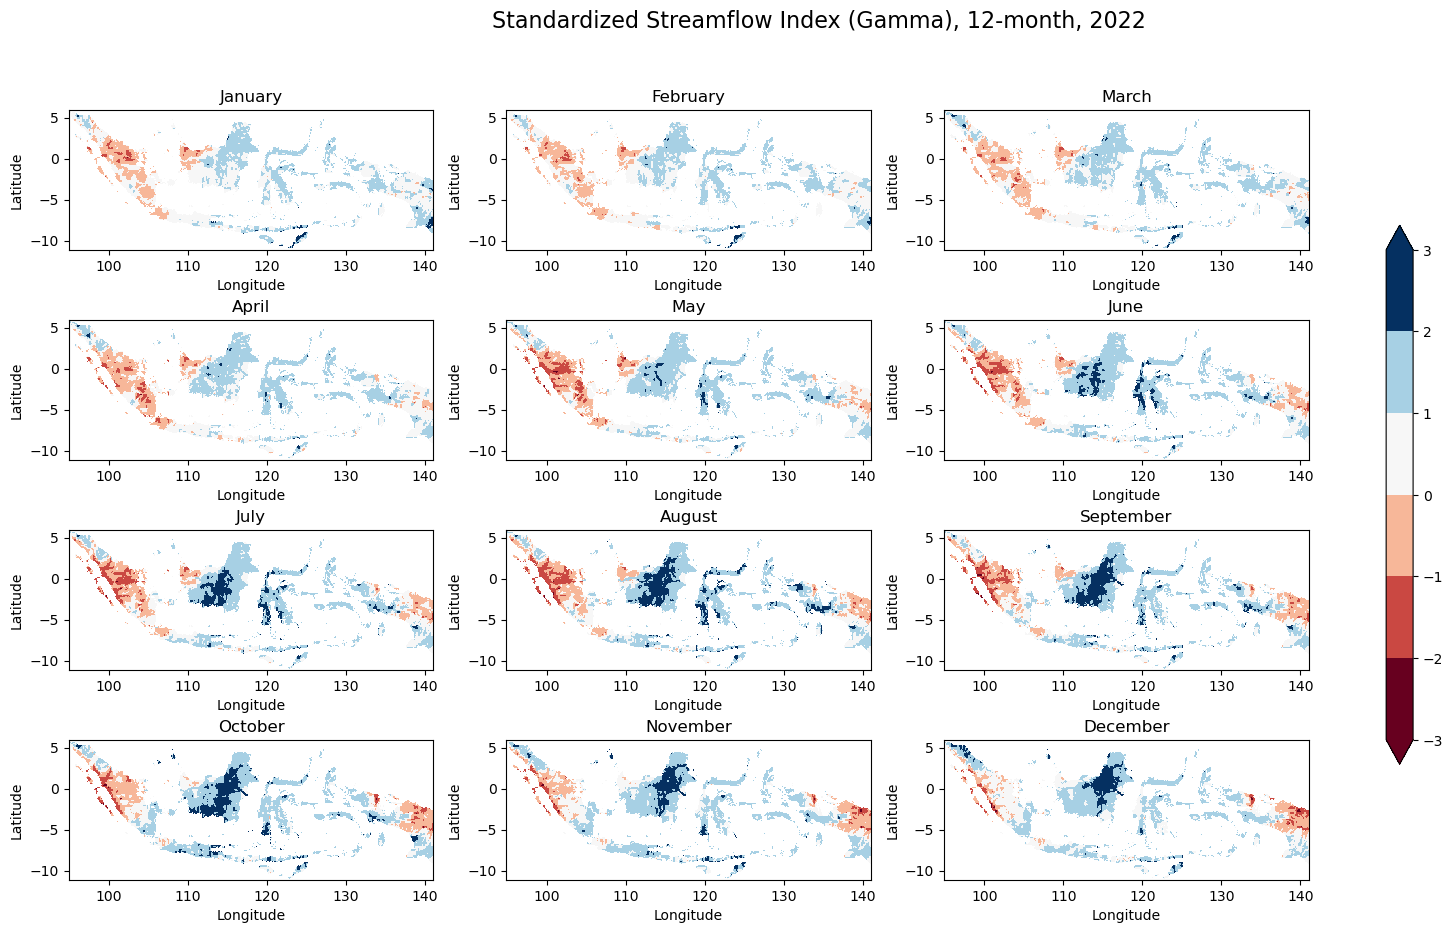

In [48]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import pandas as pd

# Load the dataset
ds = xr.open_dataset("idn_cli_ssi_gamma_12_month.nc")

# Select data from Jan - Dec 2022
start_date = "2022-01-01"
end_date = "2022-12-31"
data_2022 = ds["ssi_gamma_12_month"].sel(time=slice(start_date, end_date))

# Plotting
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 10))
fig.suptitle('Standardized Streamflow Index (Gamma), 12-month, 2022', fontsize=16, y=0.98)

# Custom discrete color map
cmap = plt.get_cmap('RdBu', 7)  # 7 discrete colors
bounds = [-3, -2, -1, 0, 1, 2, 3]
norm = colors.BoundaryNorm(bounds, cmap.N)

for i, ax in enumerate(axes.flat):
    # Plot if the data for the month exists
    if i < len(data_2022.time):
        data = data_2022.isel(time=i)
        pcm = ax.pcolormesh(data.lon, data.lat, data, cmap=cmap, norm=norm)
        
        # Set title with the corresponding month
        time_val = pd.to_datetime(str(data.time.values))
        ax.set_title(time_val.strftime('%B'))

        # Set labels
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')

# Adjust vertical spacing
plt.subplots_adjust(hspace=0.5)  # Adjust this value as needed for vertical spacing
fig.colorbar(pcm, ax=axes.ravel().tolist(), shrink=0.7, ticks=np.arange(-3, 4), extend='both')

# Save the map as a PNG
plt.savefig('../images/idn_cli_era5_ssi12_2022.png', dpi=300)
plt.show()


End of notebook.